In [36]:
# make the screen bigger!
from IPython.display import display, HTML
display(HTML(data=""" <style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    div#maintoolbar-container { width: 99%; } </style> """))

import numpy as np
import os
import pandas as pd
import csv
from datetime import datetime, timedelta
import subprocess
import matplotlib 
import matplotlib.pyplot as plt

%matplotlib notebook

# pandas display options
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.precision', 1)    # set number of significant digits to diplay n pandas

In [30]:
# Working on Subbasin file 
colnames_SUB = ['trash', 'SUB',  'GIS',  'MON',  'AREAkm2',  'PRECIPmm', 'SNOMELTmm',    'PETmm',    'ETmm', 'SWmm', 'PERCmm',   'SURQmm',   
            'GW_Qmm',   'WYLDmm',   'SYLDt/ha', 'ORGNkg/ha',    'ORGPkg/ha',    'NSURQkg/ha',   'SOLPkg/ha',    'SEDPkg/ha',    
            'LATQ(mm)', 'LATNO3kg/ha',  'GWNO3kg/ha',   'CHOLAmic/L',   'CBODUmg/L',    'DOXQmg/L', 'TNO3kg/ha',    'QTILEmm',  'TVAPkg/ha']


shed_name = "Fagaalu"

output_sub_file = os.path.join('..', shed_name, 'model', shed_name, 'Scenarios/Default/TxtInOut/', 'output.sub')

listo = []
with open(output_sub_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=' ', skipinitialspace=True)
    line_count = 0
    for row in csv_reader:
        listo.append(row)
    da_listo = listo[9:]        # cut off the headder line BS
data = da_listo            # just the good stuff


for i in data:
    splitit = i[3].split(".")               # this little blok is because SWAT Fd up the Mon column and stuck it onto the area col, why?
    i[3] = splitit[0]
    i.insert(4, float('0.' + splitit[-1]))  # the bugs and inconsistant formatting in this model are truely mind blowing...
    
df = pd.DataFrame(data, columns=colnames_SUB)    # make the data into a dataframe
del df['trash']                                  # remove random trach column
df = df.apply(pd.to_numeric)                     # make numbers numbers

# get date values onto the data, it has to split into individual dictionary of subbasins
Startdate = "20130101"
OGdate = datetime(year=int(Startdate[0:4]), month=int(Startdate[4:6]), day=int(Startdate[6:8]))

SUB_pile = {}

for i in df['SUB'].unique():
    keynam = "SUB_{}".format(i)
    SUB_pile[keynam] = df[df['SUB'] == i]
    SUB_pile[keynam] = SUB_pile[keynam] .reset_index(drop=True)    # make index start at 1
    SUB_pile[keynam]['date'] = pd.to_datetime(SUB_pile[keynam].index, unit='d', origin = OGdate )

<IPython.core.display.Javascript object>


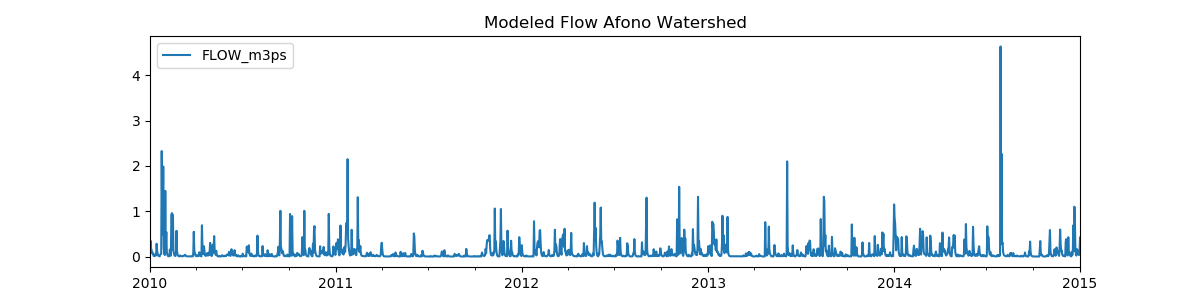

<IPython.core.display.Javascript object>


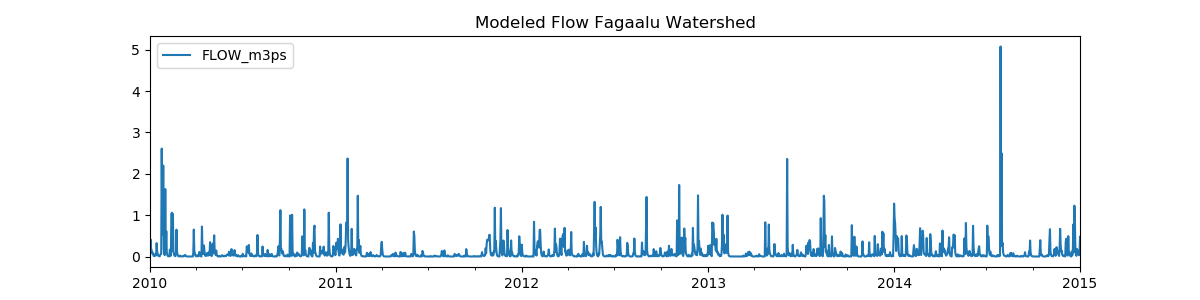

<IPython.core.display.Javascript object>


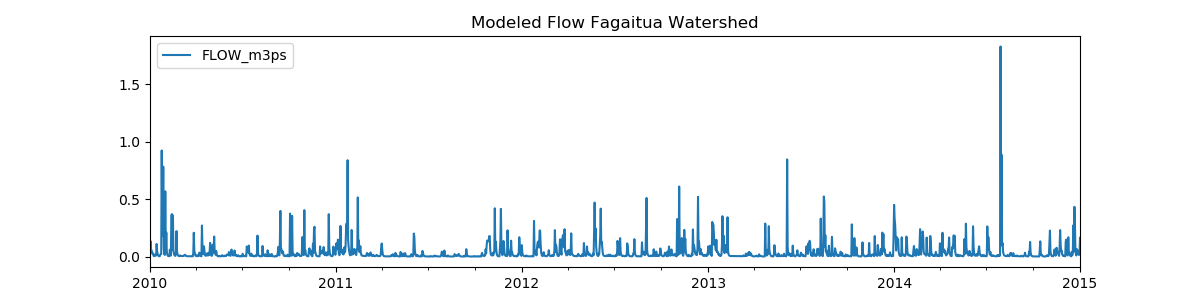

<IPython.core.display.Javascript object>


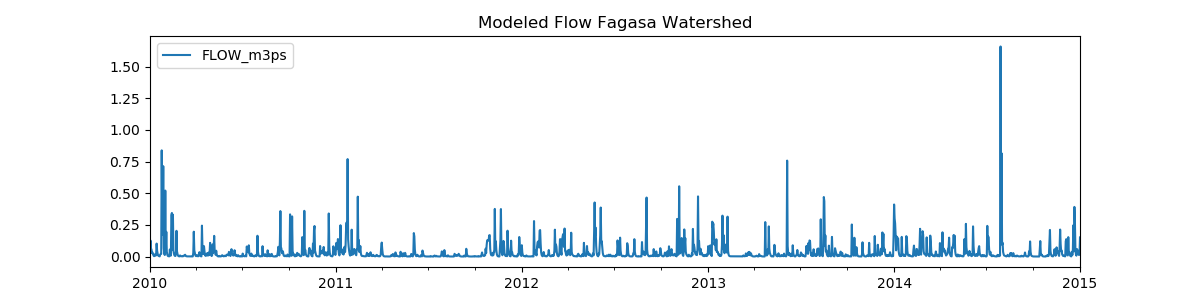

<IPython.core.display.Javascript object>


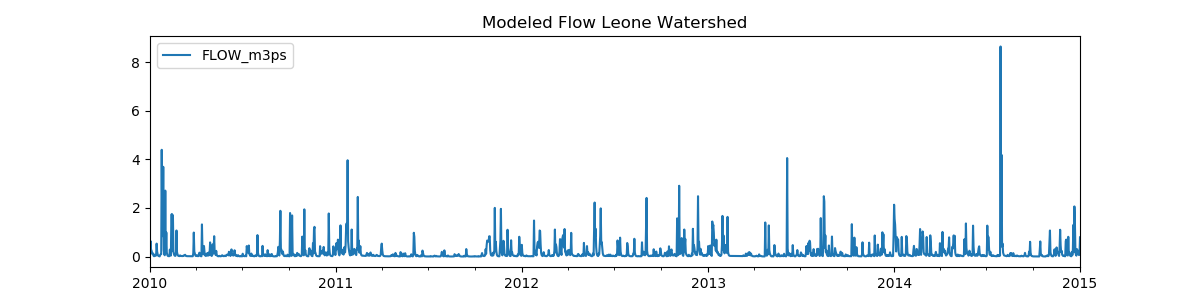

<IPython.core.display.Javascript object>


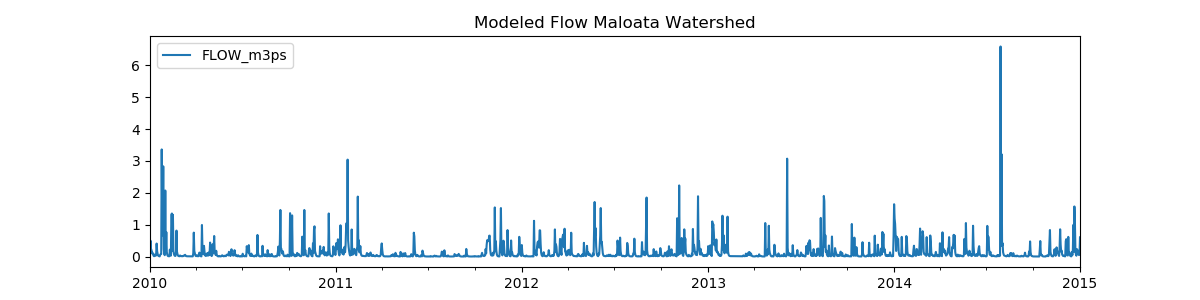

<IPython.core.display.Javascript object>


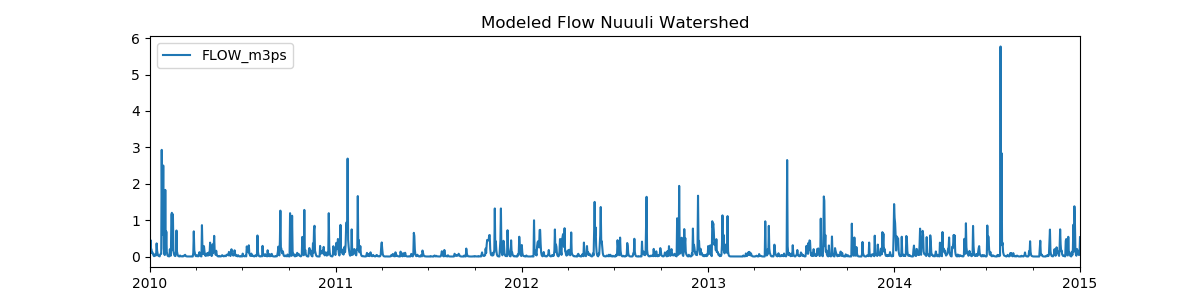

<IPython.core.display.Javascript object>


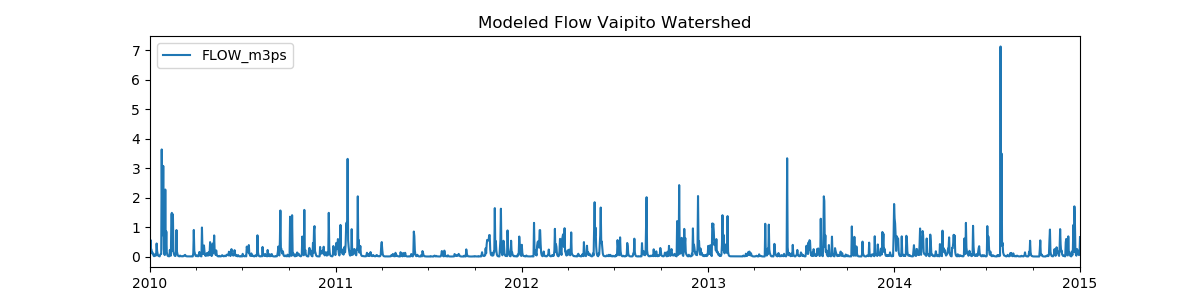

<IPython.core.display.Javascript object>


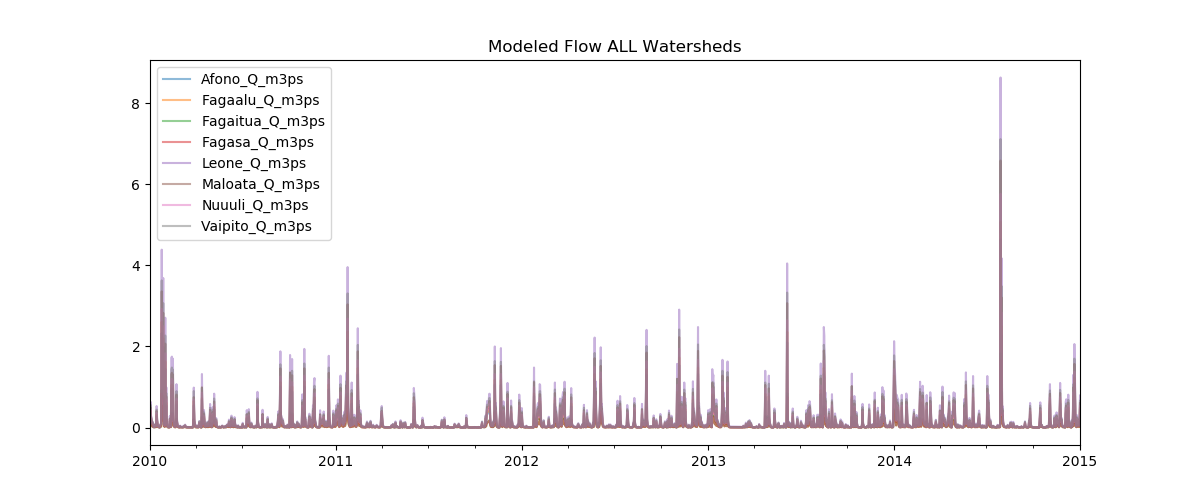

<IPython.core.display.Javascript object>


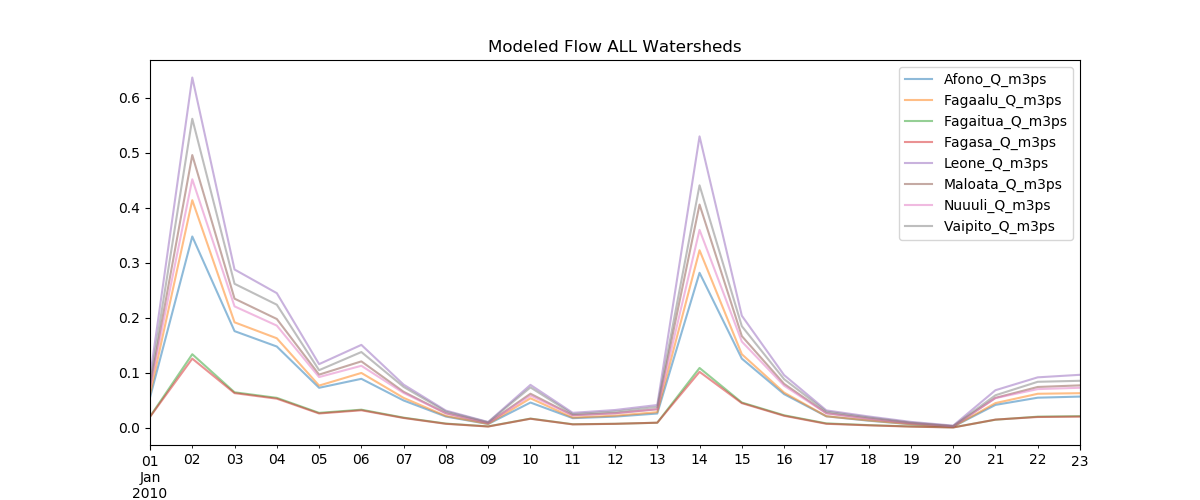

In [45]:
# working on watout.dat file Plot individual figures of flow from each watersehd
Shed_list = ['Afono', 'Fagaalu', 'Fagaitua', 'Fagasa', 'Leone', 'Maloata', 'Nuuuli', 'Vaipito' ]

for shed_name in Shed_list:
    
    output_sub_file = os.path.join('..', shed_name, 'model', shed_name, 'Scenarios/Default/TxtInOut/', 'watout.dat')

    headde = ['Year',  'Day', 'FLOW_m3ps']
    flow_df = pd.read_csv(output_sub_file, skiprows=6, skipinitialspace=True, sep='\s+', names=headde, usecols= [0,1,3])
    flow_df.index = pd.to_datetime(flow_df['Year'] * 1000 + flow_df['Day'], format='%Y%j')
    del flow_df['Year']; del flow_df['Day']
    flow_df = flow_df.apply(pd.to_numeric)                     # make numbers numbers

    figure = flow_df.plot(figsize = (12,3), title='Modeled Flow {} Watershed'.format(shed_name))
    ax = figure.get_figure()
    ax.savefig(os.path.join('..', '..',  "Figures/SWAT_model", "SWAT_flow_{}.jpg".format(shed_name) ))
    
    
# Now take  on watout.dat file and plot all series on one
Shed_list = ['Afono', 'Fagaalu', 'Fagaitua', 'Fagasa', 'Leone', 'Maloata', 'Nuuuli', 'Vaipito' ]

Q_all = flow_df.copy()       # note this relies on the execution of previous cell (LAZY!)
for shed_name in Shed_list:
    
    output_sub_file = os.path.join('..', shed_name, 'model', shed_name, 'Scenarios/Default/TxtInOut/', 'watout.dat')

    headde = ['Year',  'Day', '{}_Q_m3ps'.format(shed_name)]
    Q_df = pd.read_csv(output_sub_file, skiprows=6, skipinitialspace=True, sep='\s+', names=headde, usecols= [0,1,3])
    Q_df.index = pd.to_datetime(Q_df['Year'] * 1000 + Q_df['Day'], format='%Y%j')
    del Q_df['Year']; del Q_df['Day']
    Q_df = Q_df.apply(pd.to_numeric)                     # make numbers numbers
    
    Q_all = pd.merge(Q_all, Q_df, left_index=True, right_index=True)
    
del Q_all['FLOW_m3ps'] # get rid of lazy extra column 

# Plot all series on one figure  (This shows the differences the watershed data only makes, no calibration)
figure2 = Q_all.plot(figsize = (12,5), title='Modeled Flow ALL Watersheds', alpha = .5)
ax2 = figure2.get_figure()
ax2.savefig(os.path.join('..', '..',  "Figures/SWAT_model", "SWAT_flow_ALL.jpg"))

# plot a closeup
figure3 = Q_all['2010-01-01':'2010-01-23'].plot(figsize = (12,5), title='Modeled Flow ALL Watersheds', alpha = .5)
ax3 = figure3.get_figure()
ax3.savefig(os.path.join('..', '..',  "Figures/SWAT_model", "SWAT_flow_ALL_Closeup.jpg"))

<IPython.core.display.Javascript object>


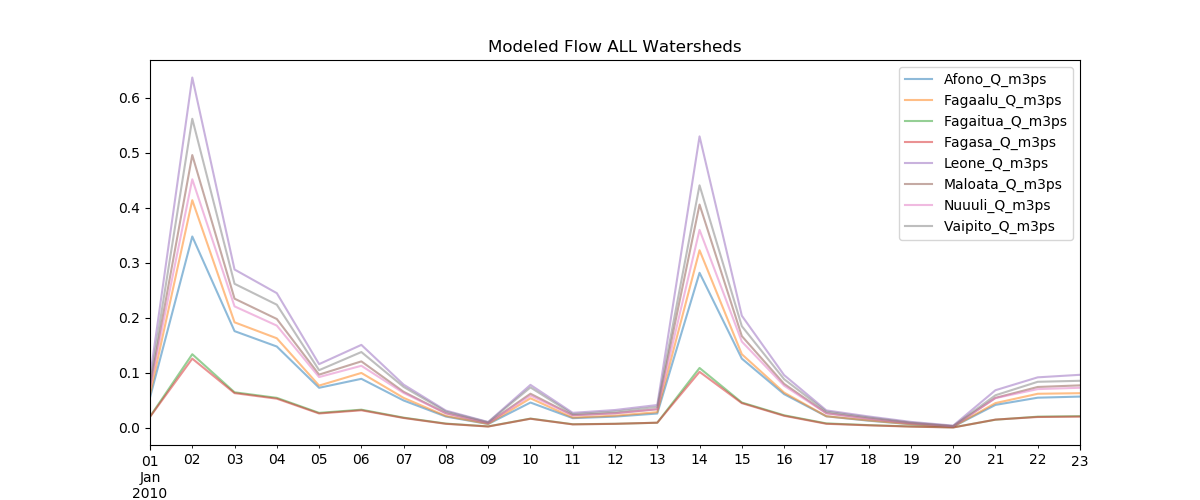

In [44]:
figure2 = Q_all['2010-01-01':'2010-01-23'].plot(figsize = (12,5), title='Modeled Flow ALL Watersheds', alpha = .5)

In [38]:
Q_all

Afono_Q_m3ps  Fagaalu_Q_m3ps  Fagaitua_Q_m3ps  Fagasa_Q_m3ps  \
2010-01-01         0.055           0.061            0.021          0.020   
2010-01-02         0.348           0.414            0.134          0.126   
2010-01-03         0.176           0.192            0.065          0.063   
2010-01-04         0.148           0.163            0.055          0.053   
2010-01-05         0.073           0.077            0.027          0.026   
...                  ...             ...              ...            ...   
2014-12-28         0.133           0.146            0.051          0.048   
2014-12-29         0.093           0.098            0.036          0.033   
2014-12-30         0.034           0.032            0.014          0.012   
2014-12-31         0.043           0.046            0.017          0.015   
2015-01-01         0.418           0.476            0.163          0.151   

            Leone_Q_m3ps  Maloata_Q_m3ps  Nuuuli_Q_m3ps  Vaipito_Q_m3ps  
2010-01-01         0.092           0.075          0.072           0.079  
2010-01-02         0.637           0.496          0.452           0.562  
2010-01-03         0.288           0.235          0.221           0.262  
2010-01-04         0.245           0.198          0.186           0.224  
2010-01-05         0.116           0.097          0.092           0.105  
...                  ...             ...            ...             ...  
2014-12-28         0.244           0.188          0.163           0.205  
2014-12-29         0.163           0.128          0.114           0.138  
2014-12-30         0.059           0.045          0.039           0.047  
2014-12-31         0.076           0.057          0.052           0.067  
2015-01-01         0.790           0.602          0.531           0.658  

[1827 rows x 8 columns]